<p align="center" width="100%">
    <img width="66%" src="https://raw.githubusercontent.com/linukc/master_dlcourse/main/images/logo.png">
</p>

In [ ]:
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")

100%|██████████| 7.99k/7.99k [00:00<00:00, 15.5MB/s]
100%|██████████| 106k/106k [00:00<00:00, 5.99MB/s]
100%|██████████| 53.2k/53.2k [00:00<00:00, 6.63MB/s]


# Signal processing (Librosa)

In [ ]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

FIG_SIZE = (10, 5)

In [ ]:
# load audio file with Librosa
signal, sample_rate = librosa.load(SAMPLE_WAV)
print(sample_rate)

22050


Text(0.5, 1.0, 'Waveform')

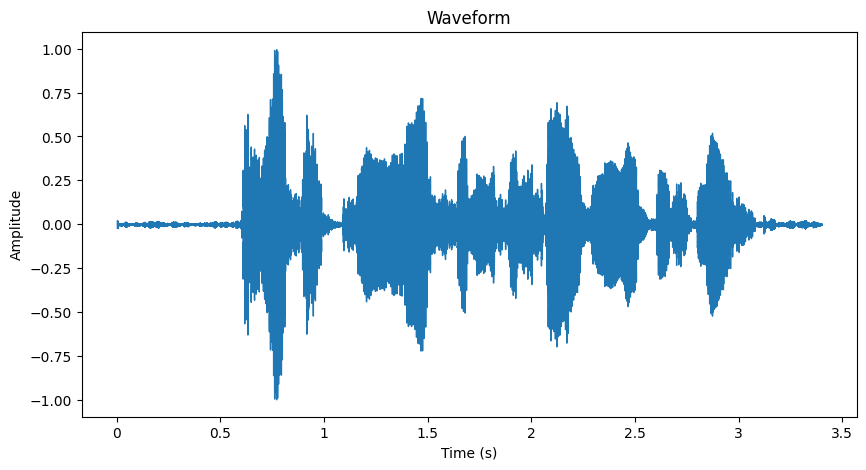

In [ ]:
# WAVEFORM
# display waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [ ]:
Audio(signal, rate=sample_rate)

Text(0.5, 1.0, 'Power spectrum')

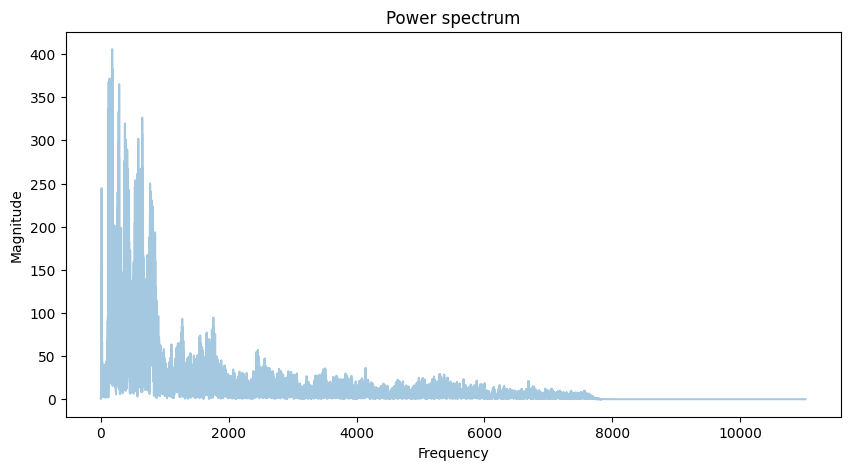

In [ ]:
# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
f = f[:int(len(spectrum)/2)]
spectrum = spectrum[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(f, spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


Text(0.5, 1.0, 'Spectrogram')

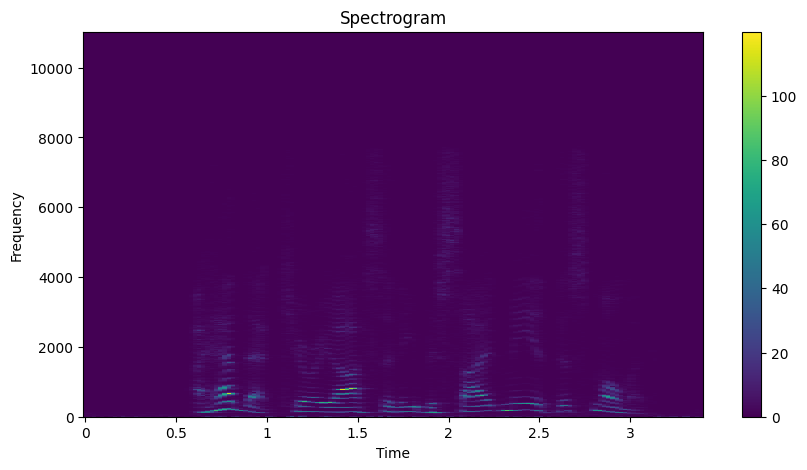

In [ ]:
# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length, cmap='viridis', x_axis="time", y_axis="hz")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

Text(0.5, 1.0, 'Spectrogram (dB)')

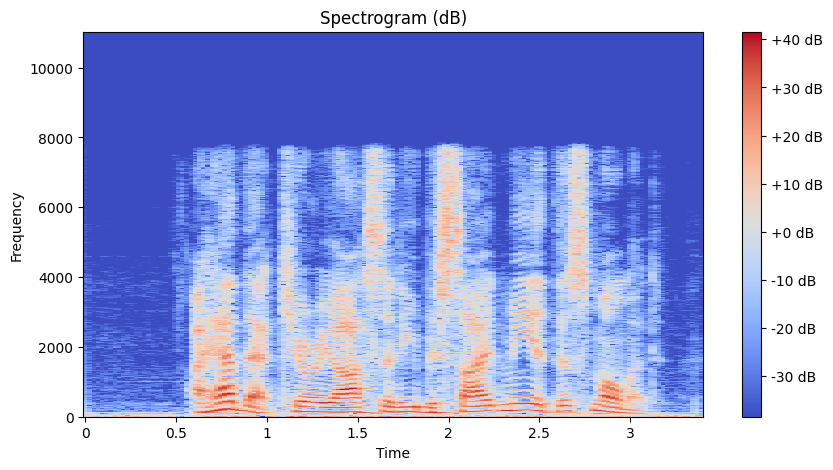

In [ ]:
# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="hz")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

Text(0.5, 1.0, 'MFCCs')

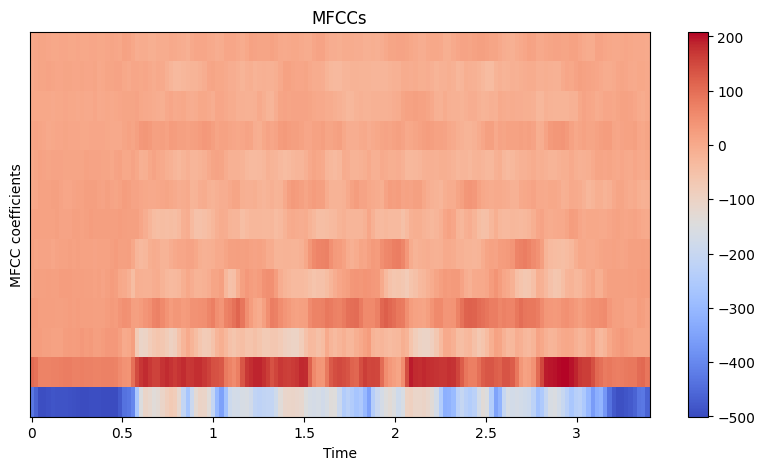

In [ ]:
# MFCCs (Mel-frequency cepstral coefficients)
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis=None)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")


# TorchAudio I/O

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to use TorchAudio's basic I/O API to inspect audio data,
load them into PyTorch Tensors and save PyTorch Tensors.

<div class="alert alert-danger"><h4>Warning</h4><p>There are multiple changes planned/made to audio I/O in recent releases.
   For the detail of these changes please refer to
   `Introduction of Dispatcher <dispatcher_migration>`.</p></div>


In [ ]:
%%capture
!pip install boto3

In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.2.1+cu121
2.2.1+cu121


In [ ]:
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config

In [ ]:
def _hide_seek(obj):
    class _wrapper:
        def __init__(self, obj):
            self.obj = obj

        def read(self, n):
            return self.obj.read(n)

    return _wrapper(obj)

## Querying audio metadata

Function :py:func:`torchaudio.info` fetches audio metadata.
You can provide a path-like object or file-like object.




In [ ]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


Where

-  ``sample_rate`` is the sampling rate of the audio
-  ``num_channels`` is the number of channels
-  ``num_frames`` is the number of frames per channel
-  ``bits_per_sample`` is bit depth
-  ``encoding`` is the sample coding format


``encoding`` can take on one of the following values:

-  ``"PCM_S"``: Signed integer linear PCM
-  ``"PCM_U"``: Unsigned integer linear PCM
-  ``"PCM_F"``: Floating point linear PCM
-  ``"FLAC"``: Flac, [Free Lossless Audio
   Codec](https://xiph.org/flac/)_
-  ``"ULAW"``: Mu-law,
   [[wikipedia](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm)_]
-  ``"ALAW"``: A-law
   [[wikipedia](https://en.wikipedia.org/wiki/A-law_algorithm)_]
-  ``"MP3"`` : MP3, MPEG-1 Audio Layer III
-  ``"VORBIS"``: OGG Vorbis [[xiph.org](https://xiph.org/vorbis/)_]
-  ``"AMR_NB"``: Adaptive Multi-Rate
   [[wikipedia](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec)_]
-  ``"AMR_WB"``: Adaptive Multi-Rate Wideband
   [[wikipedia](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband)_]
-  ``"OPUS"``: Opus [[opus-codec.org](https://opus-codec.org/)_]
-  ``"GSM"``: GSM-FR
   [[wikipedia](https://en.wikipedia.org/wiki/Full_Rate)_]
-  ``"HTK"``: Single channel 16-bit PCM
-  ``"UNKNOWN"`` None of above

**Note**

-  ``bits_per_sample`` can be ``0`` for formats with compression and/or
   variable bit rate (such as MP3).
-  ``num_frames`` can be ``0`` for GSM-FR format.




In [ ]:
url = "https://download.pytorch.org/torchaudio/tutorial-assets/steam-train-whistle-daniel_simon.wav"
with requests.get(url, stream=True) as response:
    metadata = torchaudio.info(_hide_seek(response.raw))
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


**Note**

When passing a file-like object, ``info`` does not read
   all of the underlying data; rather, it reads only a portion
   of the data from the beginning.
   Therefore, for a given audio format, it may not be able to retrieve the
   correct metadata, including the format itself. In such case, you
   can pass ``format`` argument to specify the format of the audio.

## Loading audio data

To load audio data, you can use `torchaudio.load`

This function accepts a path-like object or file-like object as input.

The returned value is a tuple of waveform (``Tensor``) and sample rate
(``int``).

By default, the resulting tensor object has ``dtype=torch.float32`` and
its value range is ``[-1.0, 1.0]``.




In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

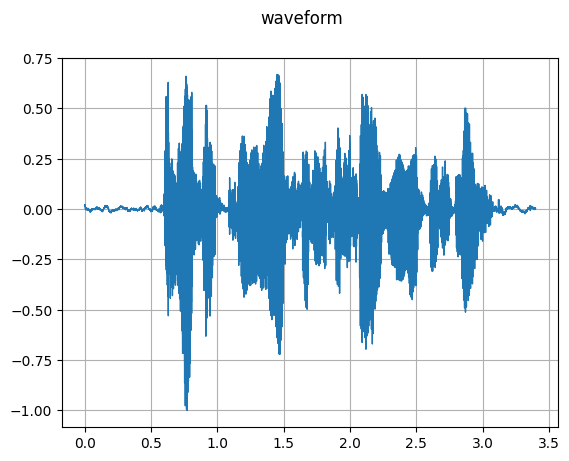

In [ ]:
plot_waveform(waveform, sample_rate)

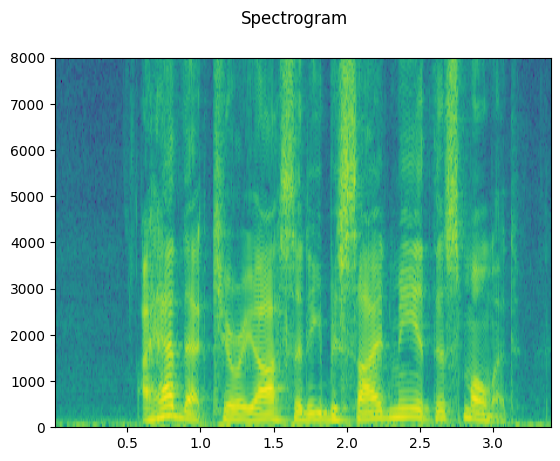

In [ ]:
plot_specgram(waveform, sample_rate)

https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

# Извлечение особенностей из звука (TorchAudio)

In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.2.1+cu121
2.2.1+cu121


In [ ]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

## Spectrogram

In [ ]:
# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

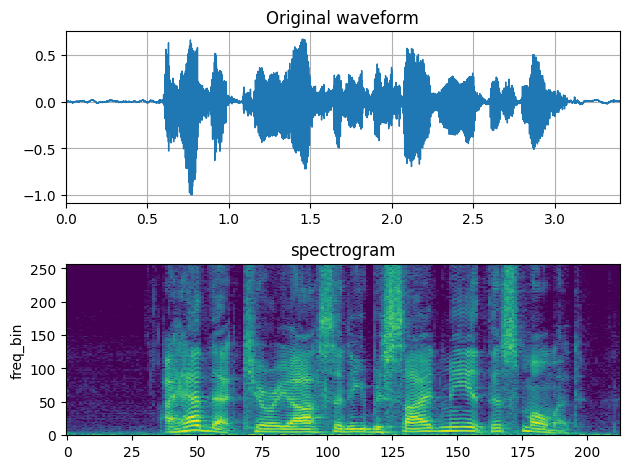

In [ ]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [ ]:
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

The value of **n_fft** determines the resolution of frequency axis. However, with the higher **n_fft** value, the energy will be distributed among more bins, so when you visualize it, it might look more blurry, even thought they are higher resolution.

**hop_length** determines the time axis resolution. By default, (i.e. **hop_length**=None and **win_length**=None), the value of **n_fft** // 4 is used. Here we use the same **hop_length** value across different **n_fft** so that they have the same number of elemets in the time axis.

In [ ]:
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(SPEECH_WAVEFORM)
    specs.append(spec)

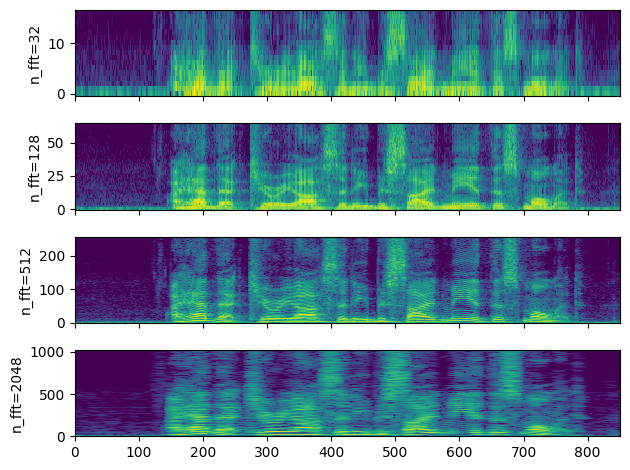

In [ ]:
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

Let’s downsample the audio and apply spectrogram with the same **n_fft** value.

In [ ]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM, SAMPLE_RATE, SAMPLE_RATE // 2)
# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE // 2, SAMPLE_RATE)

In [ ]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

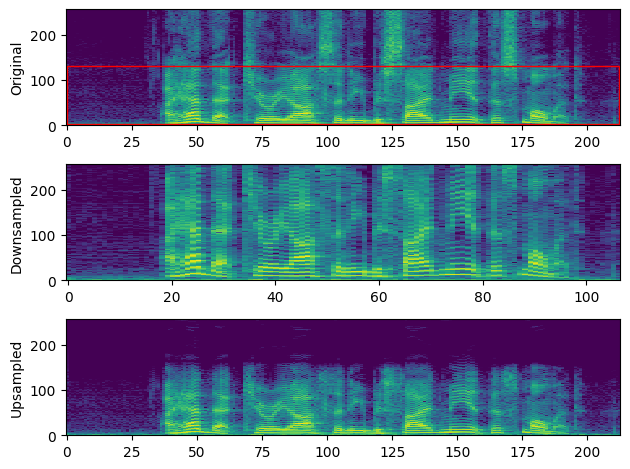

In [ ]:
# Visualize it
fig, axs = plt.subplots(3, 1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

## GriffinLim

In [ ]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(SPEECH_WAVEFORM)
reconstructed_waveform = griffin_lim(spec)

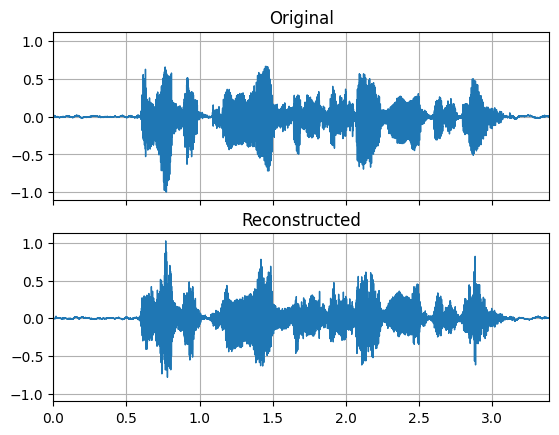

In [ ]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

## MelSpectrogram

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

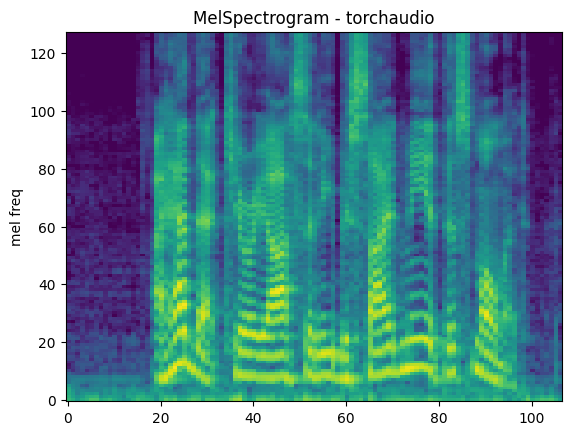

In [ ]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [ ]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=SAMPLE_RATE,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

Mean Square Difference:  1.141135380633429e-10


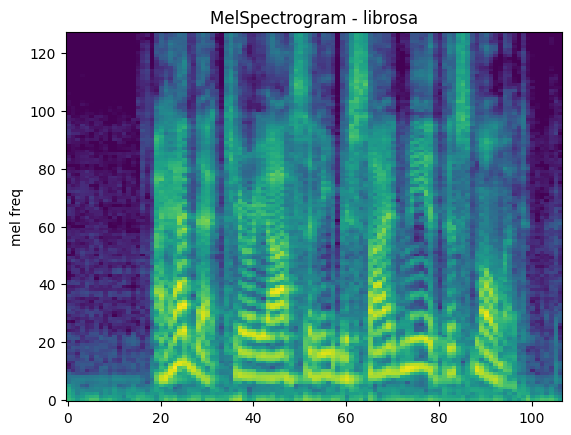

In [ ]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MFCC

In [ ]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

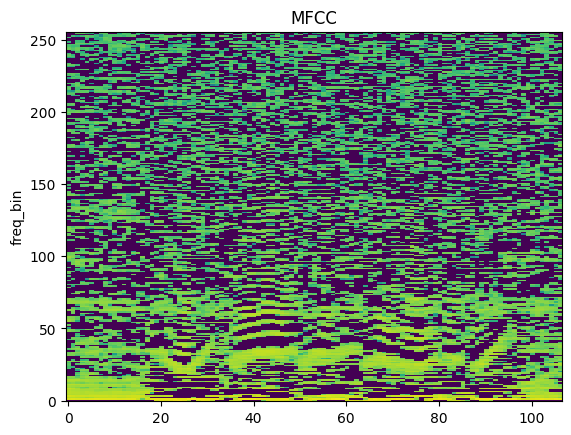

In [ ]:
plot_spectrogram(mfcc[0], title="MFCC")

## LFCC

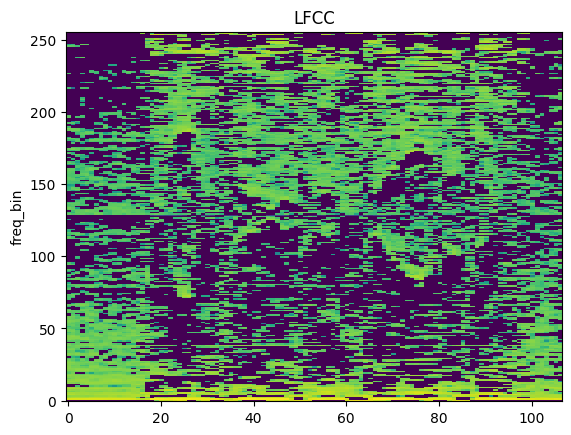

In [ ]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=SAMPLE_RATE,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0], title="LFCC")


## Pitch

In [ ]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

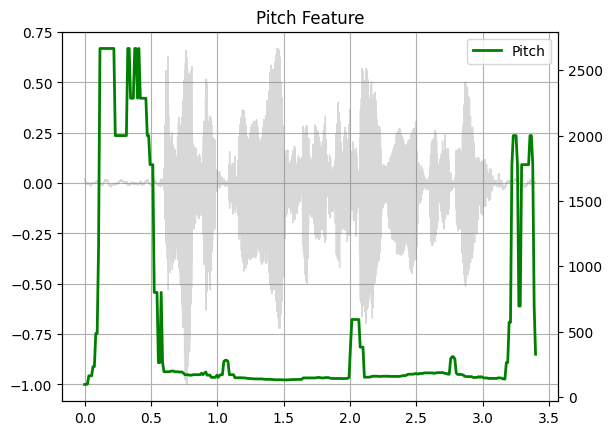

In [ ]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)

# Аугментация звука

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

In [ ]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

2.2.1+cu121
2.2.1+cu121


In [ ]:
from IPython.display import Audio

from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

100%|██████████| 427k/427k [00:00<00:00, 8.59MB/s]
100%|██████████| 31.3k/31.3k [00:00<00:00, 6.48MB/s]
100%|██████████| 78.2k/78.2k [00:00<00:00, 4.10MB/s]


## torchaudio.io.AudioEffector

In [ ]:
# Load the data
waveform1, sample_rate = torchaudio.load(SAMPLE_WAV, channels_first=False)

# Define effects
effect = ",".join(
    [
        "lowpass=frequency=300:poles=1",  # apply single-pole lowpass filter
        "atempo=0.8",  # reduce the speed
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
        # Applying echo gives some dramatic feeling
    ],
)


# Apply effects
def apply_effect(waveform, sample_rate, effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)


waveform2 = apply_effect(waveform1, sample_rate, effect)

print(waveform1.shape, sample_rate)
print(waveform2.shape, sample_rate)

torch.Size([109368, 2]) 44100
torch.Size([144642, 2]) 44100


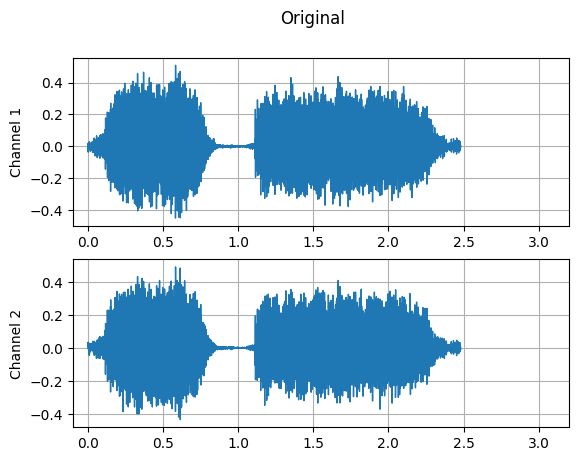

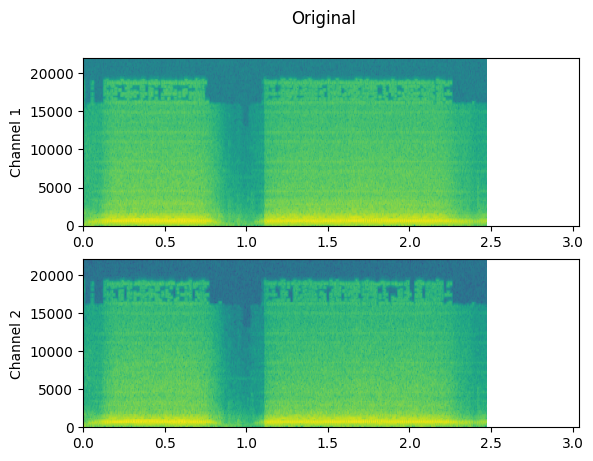

In [ ]:
plot_waveform(waveform1.T, sample_rate, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1.T, sample_rate, title="Original", xlim=(0, 3.04))
Audio(waveform1.T, rate=sample_rate)

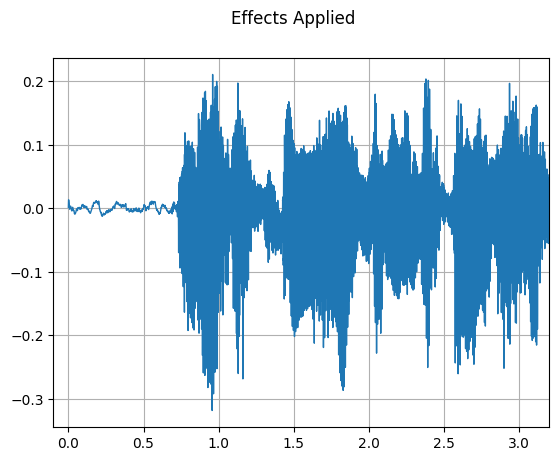

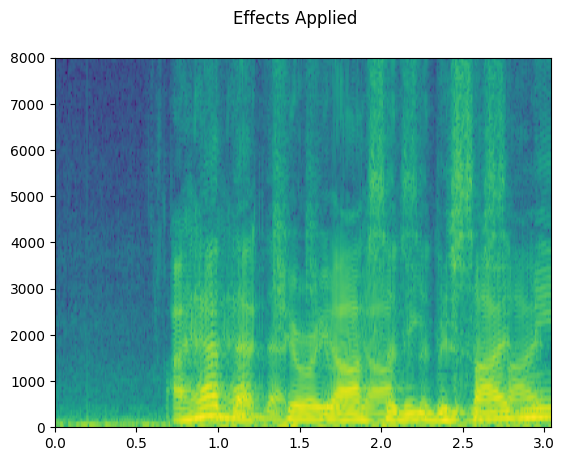

In [ ]:
plot_waveform(waveform2.T, sample_rate, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform2.T, sample_rate, title="Effects Applied", xlim=(0, 3.04))
Audio(waveform2.T, rate=sample_rate)

## Convolution reverb

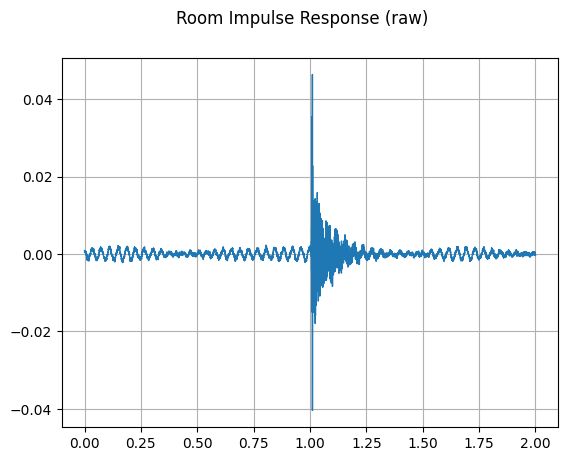

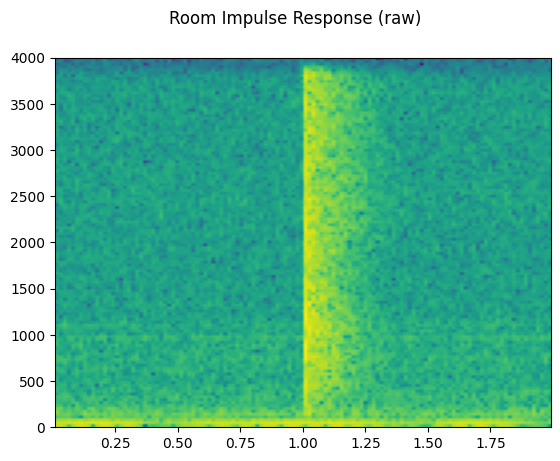

In [ ]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
Audio(rir_raw, rate=sample_rate)

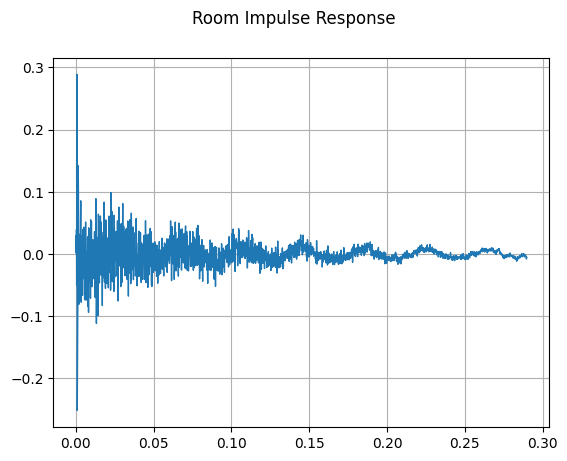

In [ ]:
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)

plot_waveform(rir, sample_rate, title="Room Impulse Response")

In [ ]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
augmented = F.fftconvolve(speech, rir)

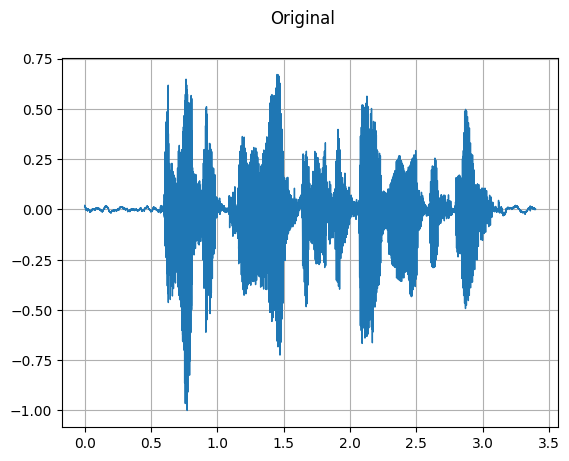

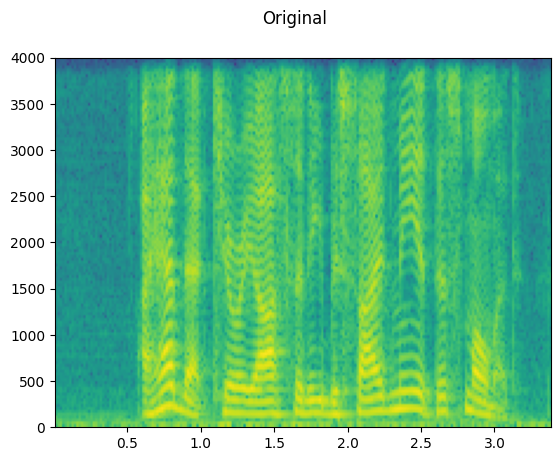

In [ ]:
plot_waveform(speech, sample_rate, title="Original")
plot_specgram(speech, sample_rate, title="Original")
Audio(speech, rate=sample_rate)

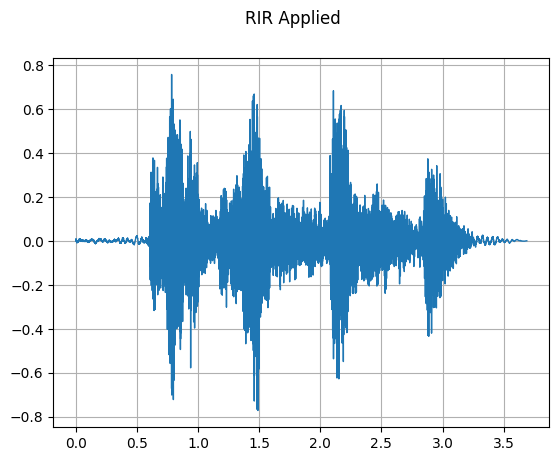

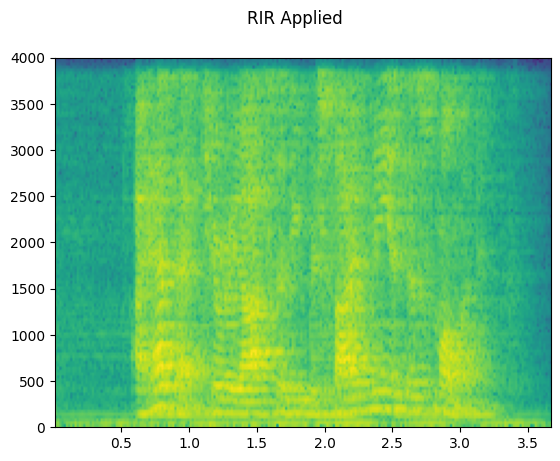

In [ ]:
plot_waveform(augmented, sample_rate, title="RIR Applied")
plot_specgram(augmented, sample_rate, title="RIR Applied")
Audio(augmented, rate=sample_rate)

## Adding background noise

In [ ]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : speech.shape[1]]

snr_dbs = torch.tensor([20, 10, 3])
noisy_speeches = F.add_noise(speech, noise, snr_dbs)

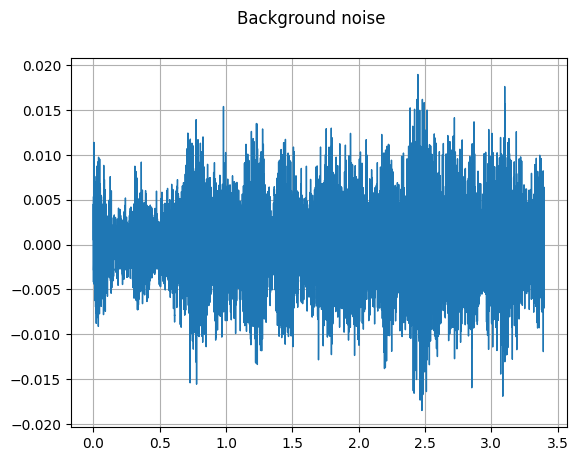

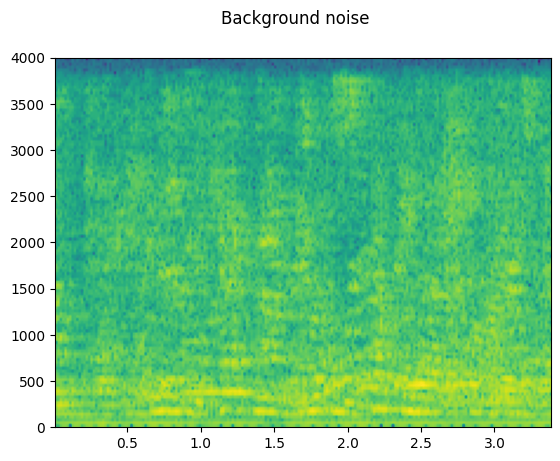

In [ ]:
plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
Audio(noise, rate=sample_rate)

## Example

audio that sounds like a person talking over a phone in a echoey room with people talking in the background

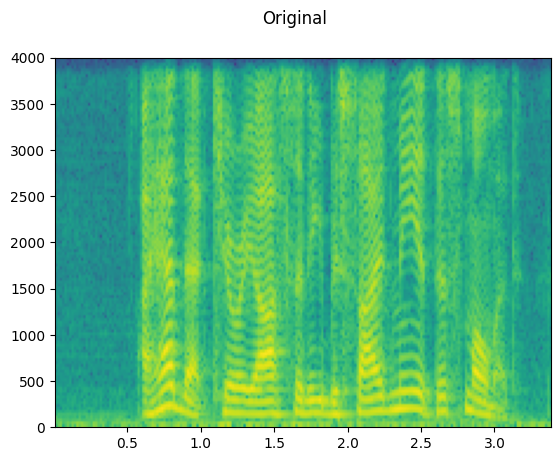

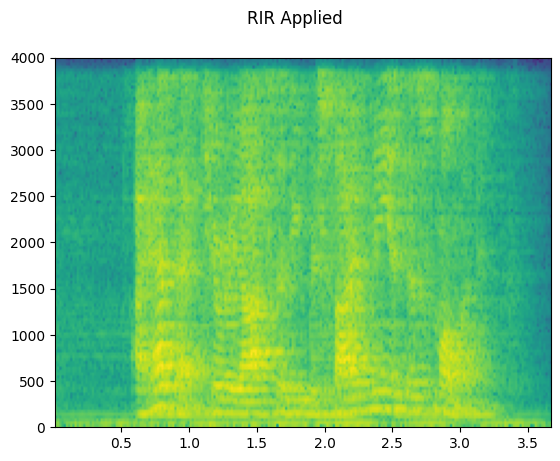

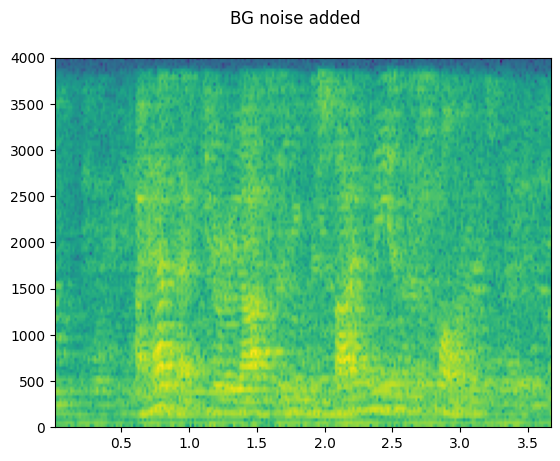

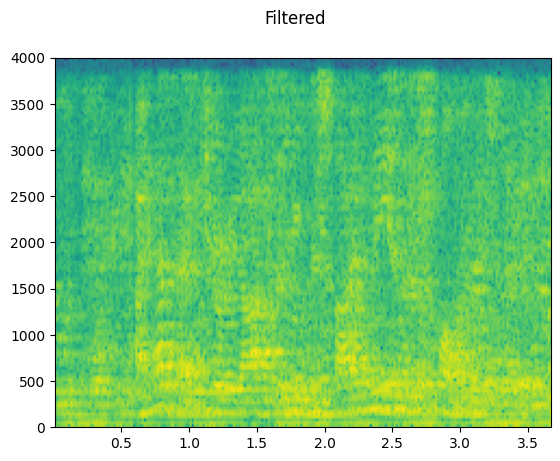

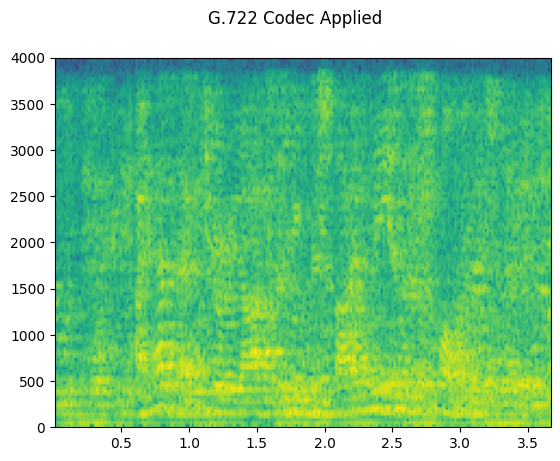

In [ ]:
def apply_codec(waveform, sample_rate, format, encoder=None):
    encoder = torchaudio.io.AudioEffector(format=format, encoder=encoder)
    return encoder.apply(waveform, sample_rate)


sample_rate = 16000
original_speech, sample_rate = torchaudio.load(SAMPLE_SPEECH)

plot_specgram(original_speech, sample_rate, title="Original")

# Apply RIR
rir_applied = F.fftconvolve(speech, rir)

plot_specgram(rir_applied, sample_rate, title="RIR Applied")

# Add background noise
# Because the noise is recorded in the actual environment, we consider that
# the noise contains the acoustic feature of the environment. Therefore, we add
# the noise after RIR application.
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : rir_applied.shape[1]]

snr_db = torch.tensor([8])
bg_added = F.add_noise(rir_applied, noise, snr_db)

plot_specgram(bg_added, sample_rate, title="BG noise added")

# Apply filtering and change sample rate
effect = ",".join(
    [
        "lowpass=frequency=4000:poles=1",
        "compand=attacks=0.02:decays=0.05:points=-60/-60|-30/-10|-20/-8|-5/-8|-2/-8:gain=-8:volume=-7:delay=0.05",
    ]
)

filtered = apply_effect(bg_added.T, sample_rate, effect)
sample_rate2 = 8000

plot_specgram(filtered.T, sample_rate2, title="Filtered")

# Apply telephony codec
codec_applied = apply_codec(filtered, sample_rate2, "g722")
plot_specgram(codec_applied.T, sample_rate2, title="G.722 Codec Applied")

In [ ]:
Audio(original_speech, rate=sample_rate)

In [ ]:
Audio(rir_applied, rate=sample_rate)

In [ ]:
Audio(bg_added, rate=sample_rate)

In [ ]:
Audio(filtered.T, rate=sample_rate2)

In [ ]:
Audio(codec_applied.T, rate=sample_rate2)

# Аугментация особенностей

In [ ]:
# When running this tutorial in Google Colab, install the required packages
# with the following.
# !pip install torchaudio librosa

import torch
import torchaudio
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)


2.2.1+cu121
2.2.1+cu121


In [ ]:
%%capture
!sudo apt install libsox-dev

In [ ]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset

In [ ]:
SAMPLE_WAV_SPEECH_PATH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def get_spectrogram(
    n_fft=400,
    win_len=None,
    hop_len=None,
    power=2.0,
):
    waveform, _ = get_speech_sample()
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(waveform)

## SpecAugment.TimeStretch

In [ ]:
spec = get_spectrogram(power=None)
stretch = T.TimeStretch()

spec_12 = stretch(spec, overriding_rate=1.2)
spec_09 = stretch(spec, overriding_rate=0.9)

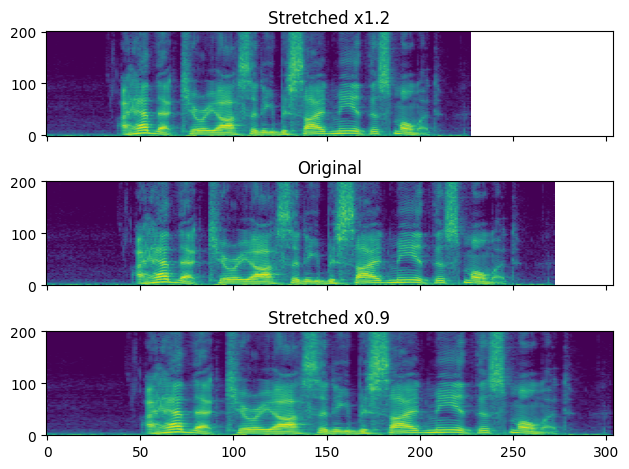

In [ ]:
def plot():
    def plot_spec(ax, spec, title):
        ax.set_title(title)
        ax.imshow(librosa.amplitude_to_db(spec), origin="lower", aspect="auto")

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
    plot_spec(axes[0], torch.abs(spec_12[0]), title="Stretched x1.2")
    plot_spec(axes[1], torch.abs(spec[0]), title="Original")
    plot_spec(axes[2], torch.abs(spec_09[0]), title="Stretched x0.9")
    fig.tight_layout()


plot()

In [ ]:
def preview(spec, rate=16000):
    ispec = T.InverseSpectrogram()
    waveform = ispec(spec)

    return Audio(waveform[0].numpy().T, rate=rate)


preview(spec)

In [ ]:
preview(spec_12)

In [ ]:
preview(spec_09)

## Time and Frequency Masking

In [ ]:
torch.random.manual_seed(4)

time_masking = T.TimeMasking(time_mask_param=80)
freq_masking = T.FrequencyMasking(freq_mask_param=80)

spec = get_spectrogram()
time_masked = time_masking(spec)
freq_masked = freq_masking(spec)

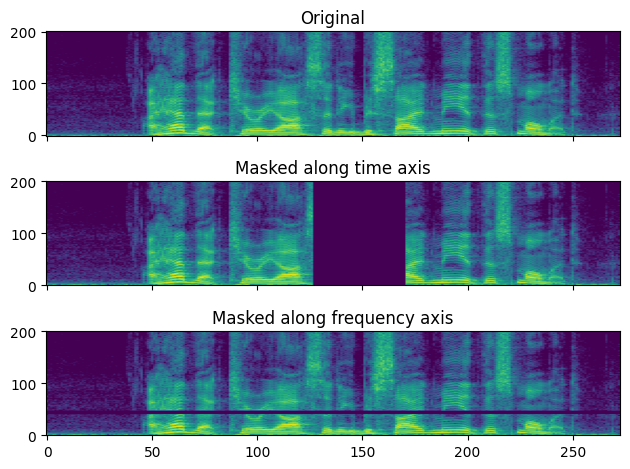

In [ ]:
def plot():
    def plot_spec(ax, spec, title):
        ax.set_title(title)
        ax.imshow(librosa.power_to_db(spec), origin="lower", aspect="auto")

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
    plot_spec(axes[0], spec[0], title="Original")
    plot_spec(axes[1], time_masked[0], title="Masked along time axis")
    plot_spec(axes[2], freq_masked[0], title="Masked along frequency axis")
    fig.tight_layout()


plot()

# Домашнее задание

Finetuning предобученной выбранной модели на выбранном датасете по аналогии с https://huggingface.co/docs/transformers/en/tasks/audio_classification или https://huggingface.co/docs/transformers/en/tasks/asr

In [ ]:
import numpy as np
# cost = np.array([[4, 1], [2, 0], [3, 2]])
cost = np.random.rand(25, 34)
from scipy.optimize import linear_sum_assignment
start = time.time()
row_ind, col_ind = linear_sum_assignment(cost)
print(time.time() - start)
#
# print(cost)
# print(row_ind)
# print(col_ind)
print("------")
print(cost[row_ind, col_ind].sum())

0.0001995563507080078
------
0.7839898177606139


In [ ]:
# row - workers, column - jobs -> output will be size of [2, workers_len / task_len (if workes > tasks)]

In [ ]:
import time